In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
import itertools
import requests
from  statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from sklearn.metrics import mean_squared_error

In [56]:
def get_data(symbol , api_key):
    url = f"https://www.alphavantage.co/query"
    params = {
        "function" : "TIME_SERIES_DAILY",
        "symbol" : symbol,
        "outputsize" : "compact",
        "apikey" : api_key

    }
    response = requests.get(url, params=params)
    data = response.json().get("Time Series (Daily)",{})
    df = pd.DataFrame(data).T.astype(float)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace = True)
    return df["4. close"]
    

In [58]:
load_dotenv(dotenv_path="../.env") 
api_key = os.getenv("api_key")

symbol = 'AAPL'
series = get_data(symbol , api_key)
print(series)

2024-12-30    252.20
2024-12-31    250.42
2025-01-02    243.85
2025-01-03    243.36
2025-01-06    245.00
               ...  
2025-05-19    208.78
2025-05-20    206.86
2025-05-21    202.09
2025-05-22    201.36
2025-05-23    195.27
Name: 4. close, Length: 100, dtype: float64


In [60]:
series.shape

(100,)

In [62]:
series.name

'4. close'

In [64]:
series.tail()

2025-05-19    208.78
2025-05-20    206.86
2025-05-21    202.09
2025-05-22    201.36
2025-05-23    195.27
Name: 4. close, dtype: float64

In [66]:
def differencing_until_stationary(series,max_diff=3):
    d=0
    while(d<=max_diff):
        result = adfuller(series)
        print(f"Differencing level : {d} | ADF p-value {result[1]}")
        if result[1] < 0.05:
            return series , d
        series = series.diff().dropna()
        d += 1
    raise exception("Series did not become stationary")

stationary_series , d = differencing_until_stationary(series)
print(d)        

Differencing level : 0 | ADF p-value 0.49052280948821325
Differencing level : 1 | ADF p-value 4.38876719550728e-07
1


<Axes: >

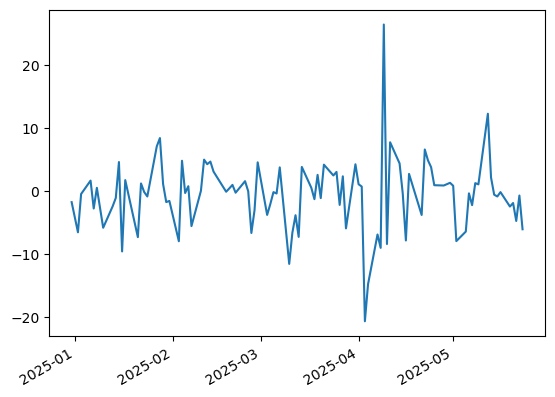

In [86]:
stationary_series.plot()

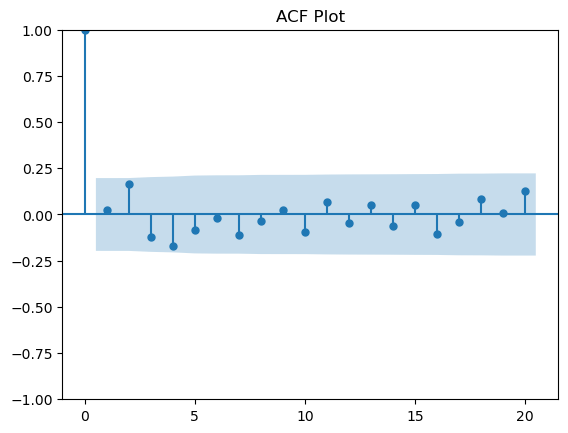

In [68]:
plot_acf(stationary_series,lags=20)
plt.title("ACF Plot")
plt.show()

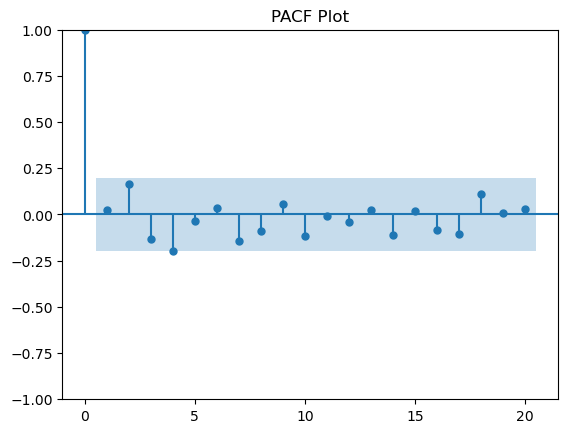

In [70]:
plot_pacf(stationary_series,lags=20)
plt.title("PACF Plot")
plt.show()

In [72]:
train = series[:-20]
test = series[-20:]

p = q = range(0, 4)
pdq = list(itertools.product(p, [d], q))


In [74]:
best_score, best_cfg = float("inf"), None
results = []

for param in pdq:
    try:
        model = ARIMA(train, order=param)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        error = mean_squared_error(test, forecast)
        results.append((param, error))

        if error < best_score:
            best_score, best_cfg = error, param

        print(f'ARIMA{param} MSE={error:.3f}')
    except Exception as e:
        print(f'Skipping ARIMA{param}: {e}')
        continue

print(f'\nBest ARIMA{best_cfg} MSE={best_score:.3f}')

C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retur

ARIMA(0, 1, 0) MSE=52.262
ARIMA(0, 1, 1) MSE=52.265
ARIMA(0, 1, 2) MSE=54.175
ARIMA(0, 1, 3) MSE=50.219
ARIMA(1, 1, 0) MSE=52.266
ARIMA(1, 1, 1) MSE=53.034
ARIMA(1, 1, 2) MSE=53.575


C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. foreca

ARIMA(1, 1, 3) MSE=36.820
ARIMA(2, 1, 0) MSE=59.880
ARIMA(2, 1, 1) MSE=57.636


C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. foreca

ARIMA(2, 1, 2) MSE=69.966
ARIMA(2, 1, 3) MSE=41.194
ARIMA(3, 1, 0) MSE=49.570
ARIMA(3, 1, 1) MSE=36.648
ARIMA(3, 1, 2) MSE=71.432
ARIMA(3, 1, 3) MSE=64.809

Best ARIMA(3, 1, 1) MSE=36.648


C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

In [84]:
best_model = ARIMA(series, order=best_cfg)
best_model_fit = best_model.fit()

forecast = best_model_fit.forecast(steps=10)
print("10-Step Forecast:")
print(forecast)


10-Step Forecast:
100    195.956429
101    195.794327
102    197.403682
103    198.478911
104    199.619577
105    200.256953
106    200.646117
107    200.744833
108    200.710184
109    200.592647
Name: predicted_mean, dtype: float64


C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\anaconda3\envs\p003\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retur

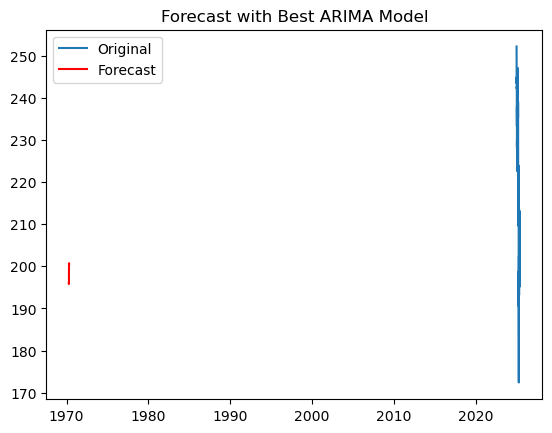

In [78]:
plt.plot(series, label='Original')
plt.plot(forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast with Best ARIMA Model')
plt.show()


In [80]:
import pickle

save_path = os.path.join("..", "Model", "model.pkl")
with open(save_path,'wb') as f:
    pickle.dump(best_model_fit,f)